# STAT3612 Lecture 7 - 	Interpretable Machine Learning

[Dr. Aijun Zhang](http://www.statsoft.org) & [Mr. Hengtao Zhang](zhanght@connetc.hku.hk) - [STAT3612 Statistical Machine Learning](http://www.statsoft.org/teaching/stat3612/)

25 October 2019

# Black-box Modeling (`xgboost`)


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
df = pd.read_csv('./BitcoinDataX.csv').iloc[:,1:]

exclude_features = ['MarketCap','MineRev','CostTransVol','CostPerTrans']
feature_names = [name for name in df.columns[1:] if name not in exclude_features]

# extract the data
X = df[feature_names].values
y = df['BitcoinPrice'].values

# train_size = 0.1
# n_train = np.int(train_size*X.shape[0])
# X_train,X_test = X[:n_train],X[n_train:]
# y_train,y_test = y[:n_train],y[n_train:]

In [3]:
# fit the model
reg = xgb.XGBRegressor()
reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [4]:
from sklearn.metrics import r2_score
r2_score(y,reg.predict(X))

0.9879338950652532

## Variable Importance

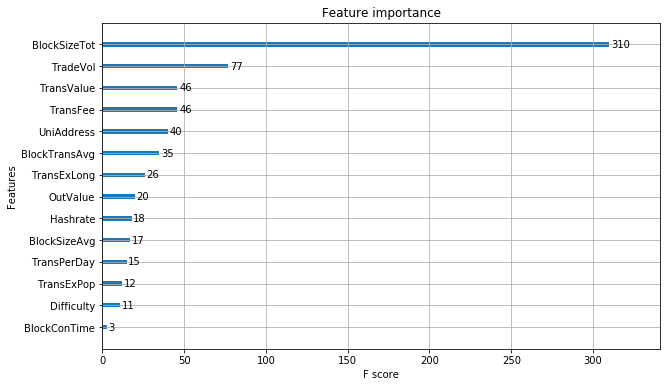

In [24]:
import matplotlib.pyplot as plt

reg.get_booster().feature_names = feature_names
# plot the variable importance
plt.figure(figsize=(10,6))
ax = plt.gca()
xgb.plot_importance(reg,ax=ax,max_num_features=len(feature_names))
plt.show()

# a) InterpretML

In [6]:
!pip install -U interpret

Requirement already up-to-date: interpret in /home/r7user3/anaconda2/envs/maskrcnn/lib/python3.7/site-packages (0.1.18)


In [7]:
from interpret.perf import RegressionPerf
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [8]:
reg.get_booster().feature_names = ['f'+str(i) for i in range(len(feature_names))]
blackbox_perf = RegressionPerf(reg.predict).explain_perf(X, y, name='Blackbox')
iplot(blackbox_perf.visualize())

## Partial Dependence Plot

In [9]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=reg.predict, data=X,feature_names=feature_names)
pdp_global = pdp.explain_global(name='Partial Dependence')

In [10]:
iplot(pdp_global.visualize(1))

In [11]:
iplot(pdp_global.visualize(0))

## Local Interpretability

In [12]:
from interpret.blackbox import LimeTabular
lime = LimeTabular(predict_fn=reg.predict, data=X, random_state=1,feature_names=feature_names)
lime_local = lime.explain_local(X[:4], y[:4], name='LIME')
iplot(lime_local.visualize(3))

# b) LIME

In [13]:
!pip install lime

In [14]:
import lime
import lime.lime_tabular

In [15]:
# define the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                   feature_names=feature_names, 
                                                   class_names=['BitcoinPrice'],
                                                   verbose=True, mode='regression')

In [16]:
exp = explainer.explain_instance(X[3], reg.predict,num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 7422.5451995409685
Prediction_local [4045.59129401]
Right: 1176.4927


# c) SHAP

In [17]:
!pip install shap

In [18]:
import shap
shap.initjs()
# define the explainer
explainer = shap.TreeExplainer(reg)
# calculate the shape value
shap_values = explainer.shap_values(X)

## Local Interpretability

In [19]:
i = 3
# force plot
shap.force_plot(explainer.expected_value, shap_values[i,:], X[i],feature_names=feature_names)

In [20]:
shap.force_plot(explainer.expected_value, shap_values, X, feature_names=feature_names)

## Global Interpretability

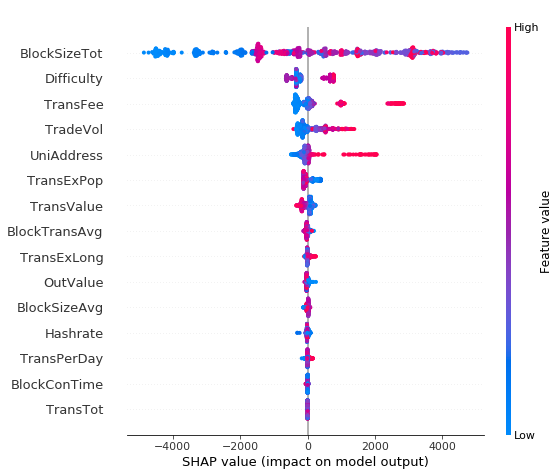

In [21]:
# summary plot
shap.summary_plot(shap_values, X,feature_names)

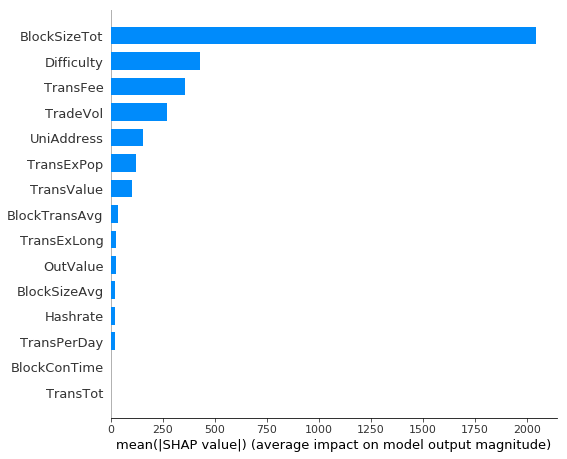

In [22]:
shap.summary_plot(shap_values, X, plot_type="bar",feature_names=feature_names)

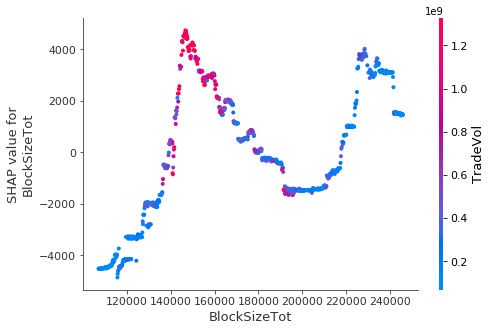

In [23]:
# dependence plot of SHAP value
shap.dependence_plot(1, shap_values, X,feature_names,interaction_index='TradeVol')